In [52]:
import torch
import torch.nn as nn
import torchvision
from torchmetrics import Accuracy
from torch.utils.data import DataLoader
from dataclasses import dataclass

from tqdm import tqdm

import sys

sys.path.append('..')

from matplotlib import pyplot as plt

from datasets import get_datasets
from models.losses import MdTripletLoss

import numpy as np
from scipy.stats import shapiro, ttest_ind

In [168]:
@dataclass
class Config:
    hidden_size: int = 5
    num_domains: int = 4
    beta_contr: float = 0.3
    trunc_data_size: int = 64
    channels: int = 16
    layers: int = 6
    
    batch_size: int = 16
    num_epochs: int = 5
    lr: float = 1e-3

config = Config()
contr_loss = MdTripletLoss()

In [169]:
ds_names = ['MNIST-0'] + ['MNIST-0'] * 10

ds_names = [f'MNIST-{i * 15}' for i in range(config.num_domains)]

ds_names = [f'MNIST-{i * 30}' for i in range(config.num_domains)]

ds_names = ['MNIST-0', 'MNIST-0', 'MNIST-180', 'MNIST-180']

train_dsets, test_dsets = get_datasets(ds_names[:config.num_domains], 28, 1)
test_dloaders = [DataLoader(ds, shuffle=False, batch_size=config.batch_size, num_workers=4,
                             drop_last=False)
                  for ds in test_dsets]

# Multidomain model

The model has CNN feature extractors for each domain with common logits head

In [108]:
class Layer(nn.Module):
    def __init__(self, channels: int = 16):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
    def forward(self, x):
        return x + self.net(x)


class CnnFeatureExtractor(nn.Module):
    def __init__(self, channels: int = 16, num_layers: int = 3):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        for i in range(num_layers):
            self.net.add_module(f'layer_{i}', Layer(channels))
        self.net.add_module('avg', nn.AdaptiveAvgPool2d((4, 4)))
        
    def forward(self, x: torch.Tensor):
        return self.net(x)
    

class MdCNN(nn.Module):
    def __init__(self, channels: int = 16, num_layers: int = 3, n_domains: int = 1):
        super().__init__()
        
        self.nets = nn.ModuleList([CnnFeatureExtractor(channels, num_layers) for _ in range(n_domains)])
        
        self.head = nn.Sequential(nn.Flatten(),
                                  nn.Linear(16 * channels, 10))
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, x: torch.Tensor, domain_idx: int):
        hs = self.nets[domain_idx](x)
        logits = self.head(hs)
        return {'out': logits, 'hs': hs}
    
    def logits_and_loss(self, x, y, domain_idx: int):
        forward_out = self(x, domain_idx)
        logits = forward_out['out']
        loss = self.loss_fn(logits, y)
        return {'logits': logits, 'loss': loss, 'hs': forward_out['hs']} 
    

In [109]:
m = MdCNN(8, 3, 1)
x = torch.randn(8, 1, 28, 28)
print(m(x, 0)['out'].shape)
y = torch.randint(10, size=(8,))
m.logits_and_loss(x, y, 0)['loss']

torch.Size([8, 10])


tensor(2.3557, grad_fn=<NllLossBackward0>)

## Single model setup

### Training, w/o contrastive, just CE-loss

In [183]:
def evaluate(model, dl, domain_idx):
    model.eval()
    n_corr = 0
    n_total = 0
    for x, y in dl:
        with torch.no_grad():
            logits = model(x, domain_idx)['out']
        n_corr += (logits.argmax(-1) == y).sum().item()
        n_total += y.shape[0]
    return n_corr / n_total

In [188]:
dl = DataLoader([train_dsets[0][i] for i in range(config.trunc_data_size * 5)],
                shuffle=True, batch_size=config.batch_size, num_workers=2)

In [195]:
model = MdCNN(config.channels, config.layers, 1)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)

In [196]:
losses = []
acc = []
test_acc = []

for epoch in range(config.num_epochs + 250):
    model.train()
    for step, (x, y) in enumerate(dl):
        if step * config.batch_size > config.trunc_data_size:
            break
        model_out = model.logits_and_loss(x, y, 0)
        loss = model_out['loss']
        opt.zero_grad()
        loss.backward()
        losses.append(loss.item())
        metric = (model_out['logits'].argmax(-1) == y).sum() / y.shape[0]
        acc.append(metric)
        opt.step()
    if epoch % 30 == 0:
        test_acc.append(evaluate(model, test_dloaders[0], 0))

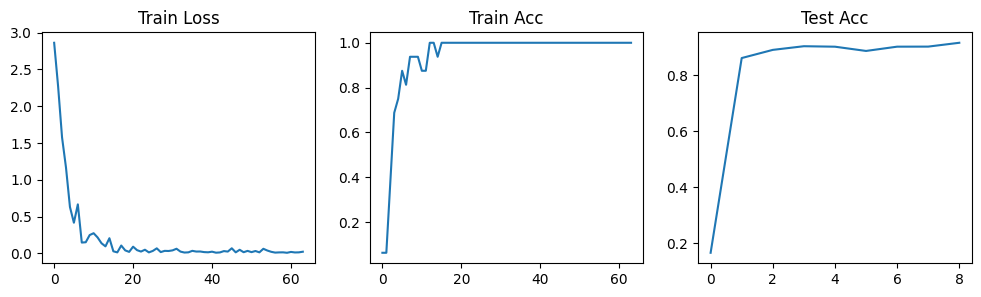

0.9158


In [197]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(losses[::20])
axs[0].set_title('Train Loss')

axs[1].plot(acc[::20])
axs[1].set_title('Train Acc')

axs[2].plot(test_acc)
axs[2].set_title('Test Acc')
plt.show()
print(max(test_acc))

### Results

### Layers = 3, channels = 8

max test acc: 75.36 ; 68.55 ; 73.52; 67.49 ; 69.7 (trunc data size)

### Layers = 6, channels = 16

max test acc : 78.37 ; 80.95; 77.76 (trunc data size)

max test acc : 0.8818 ; 0.9303; 0.9158 (5 * trunc data size) => mean acc = 90.93 


In [199]:
single_results = [88.18, 93.03, 91.58]
# print(np.mean(single_results))

single_results = [75.36, 68.55, 73.52, 67.49, 69.7]
single_results = [78.37, 80.95, 77.76]
print(f'Mean test acc {np.mean(single_results)}')

Mean test acc 79.02666666666666


In [123]:
shapiro(single_results)

ShapiroResult(statistic=0.8872136473655701, pvalue=0.3458847999572754)

### Single model contrastive loss only

In [176]:
dl = DataLoader(train_dsets[0], shuffle=True, batch_size=32, num_workers=2)
len(dl)

1875

In [177]:
model = MdCNN(16, 3, 1)
opt = torch.optim.Adam(model.parameters(), lr=config.lr)

In [114]:
losses = []
for epoch in range(1):
    for x, y in tqdm(dl):
        model_out = model.logits_and_loss(x, y, 0)
        c_loss = contr_loss.forward(model_out['hs'], model_out['hs'], y, y)
        opt.zero_grad()
        c_loss.backward()
        opt.step()
        losses.append(c_loss.item())

100%|███████████████████████████████████████████████████████████| 1875/1875 [00:58<00:00, 32.11it/s]


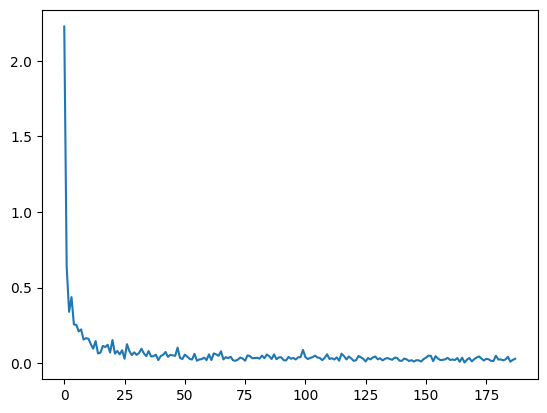

In [115]:
plt.plot(losses[::10])

### Results

Single model contrastive loss tends to zero => OK

# Setup with contrastive loss (between domains + within domains)

Setup:

__Model_k__ Train on the subsample of MNIST-k. Its size is trunc_data_size


In [170]:
# subsample from each dataset
np.random.seed(0)
sampled_ids = [np.random.choice(len(train_dsets[0]), size=(config.trunc_data_size),
                                replace=False) for _ in range(config.num_domains)]

train_dloaders = [DataLoader([ds[idx] for idx in ids],
                            batch_size=config.batch_size,
                            shuffle=True,
                            drop_last=True,
                            num_workers=2) for ds, ids in zip(train_dsets, sampled_ids)]

In [171]:
[len(dl) for dl in train_dloaders]

[4, 4, 4, 4]

In [178]:
model = MdCNN(config.channels, config.layers, config.num_domains)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)

In [179]:
losses = [[] for _ in range(config.num_domains)]
contr_losses = []
acc = [[] for _ in range(config.num_domains)]
test_acc = [[] for _ in range(config.num_domains)]

for epoch in tqdm(range(100)):
    model.train()
    for step, batches in enumerate(zip(*train_dloaders)):
        x = [batch[0] for batch in batches]
        y = [batch[1] for batch in batches]
        hidden_states = []
        total_loss = torch.tensor(0.0).requires_grad_()
        for domain_idx in range(config.num_domains):
            model_out = model.logits_and_loss(x[domain_idx], y[domain_idx], domain_idx)
            acc[domain_idx].append((model_out['logits'].argmax(-1) == y[domain_idx]).float().mean())
            loss = model_out['loss']
            losses[domain_idx].append(loss.item())
            total_loss = total_loss + loss / config.num_domains
            opt.zero_grad()
            hidden_states.append(model_out['hs'])
        # computer contrastive lossess
        for d1 in range(config.num_domains):
            for d2 in range(d1, config.num_domains):
                # if d2 != d1 + 1:  # only between domains
                    # break
                c_loss = contr_loss(hidden_states[d1], hidden_states[d2], y[d1], y[d2]) * 2\
                    / config.num_domains / (config.num_domains + 1)
                total_loss = total_loss + config.beta_contr * c_loss
        
        contr_losses.append(c_loss.item())

        total_loss.backward()
        opt.step()   
    
    if epoch % 20 == 0:
        for domain_idx in range(config.num_domains):
            test_acc[domain_idx].append(evaluate(model, test_dloaders[domain_idx], domain_idx))

100%|█████████████████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


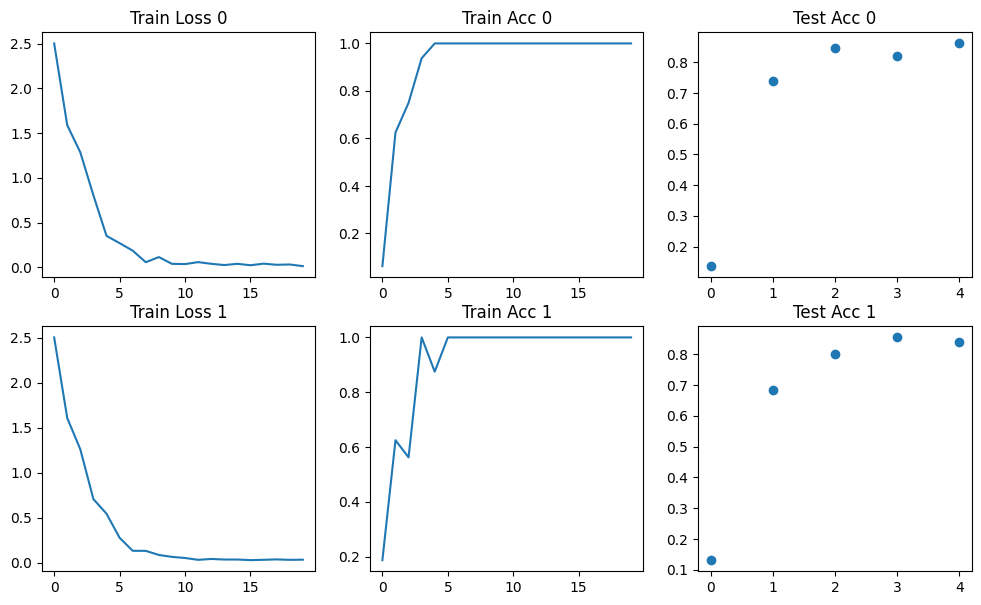

[0.1314   0.715325 0.81205  0.828575 0.83865 ]
[[0.1366 0.739  0.845  0.8216 0.8615]
 [0.1318 0.6835 0.8006 0.8544 0.8394]
 [0.1269 0.7276 0.7876 0.8105 0.8214]
 [0.1303 0.7112 0.815  0.8278 0.8323]]


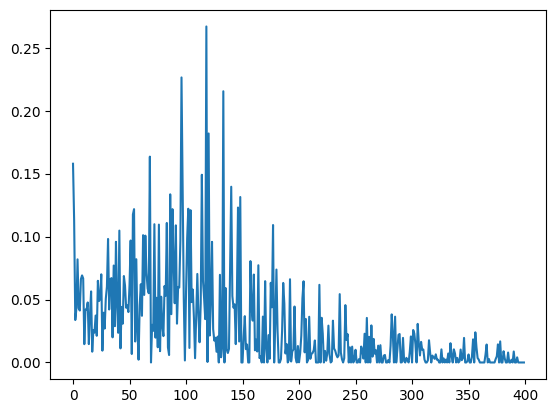

In [180]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
for idx in range(2):
    axs[idx, 0].plot(losses[idx][::20])
    axs[idx, 0].set_title(f'Train Loss {idx}')

    axs[idx, 1].plot(acc[idx][::20])
    axs[idx, 1].set_title(f'Train Acc {idx}')

    axs[idx, 2].plot(test_acc[idx], 'o')
    axs[idx, 2].set_title(f'Test Acc {idx}')
plt.show()
plt.plot(contr_losses)
print(np.array(test_acc).mean(0))
print(np.array(test_acc))

### Contrastive only (within domain losses + between domain loss)

### Conclusion:

### Num layers = 3, channels = 8

1. Mean test accuracies: 82.75 ; 78.42 ; 79.32 ; 82.13; 84.64 (MNIST-15 + 4 mnist-0) => acc gain = 10.53

2. Mean test accuracies: 76.502 ; 74.85; 79.91 (MNIST-0, MNIST-15, MNIST-30, MNIST-45, MNIST-90) => acc gain = 6.16

3. Mean test accuracies: 0.75476 ; 0.75232 ; 75.61 (MNIST-0, MNIST-30, MNIST-60, MNIST-90, MNIST-120) => acc gain 4.51

### Num layers = 6, channels = 16

Note that single domain * 5 gives 90.93 accuracy which is + 10 accuracy gain!!!

1. (MNIST-0, MNIST-30, MNIST-60, MNIST-90, MNIST-120):  0.81334 ; 0.80046 ; 0.80694 => acc gain = 1.66
2. (MNIST-0, MNIST-30, MNIST-60, MNIST-90, MNIST-120), only between domains contastive: 0.75138 ; 0.67522 ; 0.6799 => acc gain -8.8

__Use within domain contastive loss !!!__

3. (2 * MNIST-0, 2 * MNIST-180); 0.830825; 0.808575; 0.83865 => acc gain = 3.58

### \# TODO: try the same setup, but CIFAR-10. The hypothesis is that gain will be around 10

In [181]:
md_results = [82.75, 78.42, 79.32, 82.13, 84.64]
md_results = [76.50, 74.85, 79.91]
md_results = [75.48, 75.23, 75.61]
md_results = [81.334, 80.04, 80.69]
md_results = [75.14, 67.52, 67.99]
md_results = [83.08, 80.86, 83.87]
print(f'Mean acc {np.mean(md_results)}')

Mean acc 82.60333333333334


In [182]:
print(f'Acc gain: {np.mean(md_results) - np.mean(single_results)}')

Acc gain: 3.576666666666682


In [57]:
shapiro(md_results)

ShapiroResult(statistic=0.9452659487724304, pvalue=0.7033655643463135)

In [58]:
ttest_ind(single_results, md_results).pvalue < 0.05

True